Text(0.5, 0.92, 'Simulation Box')

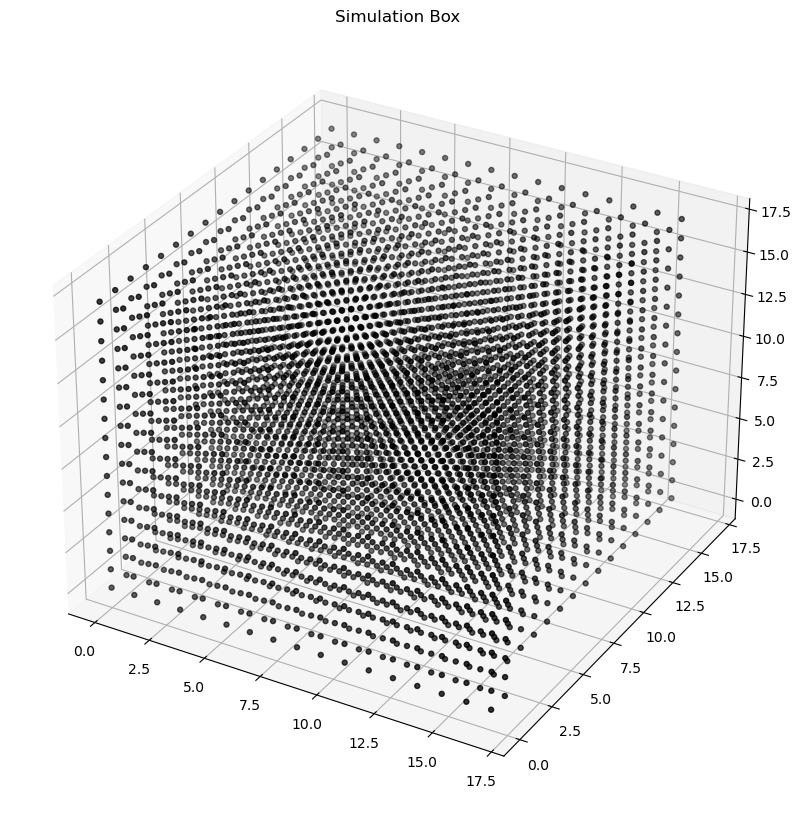

In [38]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
np.random.seed(0)  # Seed for reproducibility

L = 18.0
rho = 0.75
T = 1
Peos = 0.9891
N = int((L**3) * rho)

pold = np.zeros((N, 3))
# initial locations
nop = 0
for x in range(17):
    for y in range(17):
        for z in range(16):
            if nop < N:
                pold[nop] = np.array([x * 1.05, y * 1.05, z * 1.125])
                nop += 1


# Plotting the simulation box
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pold[:, 0], pold[:, 1], pold[:, 2], s=13, c='black')
ax.set_title('Simulation Box')

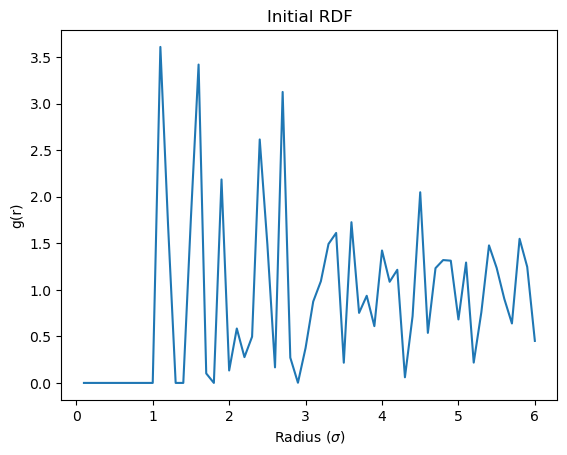

In [39]:
# Compute differences
delta_xyz = pold[:, None, :] - pold[None, :, :]
delta_xyz -= L * np.round(delta_xyz / L)
rx = delta_xyz[:, :, 0]
ry = delta_xyz[:, :, 1]
rz = delta_xyz[:, :, 2]

# Compute distances
r = np.sqrt(rx**2 + ry**2 + rz**2)

# initial RDF calculation
dr = 0.1
Radius = np.arange(0.1, 6.1, 0.1)
grinit = np.zeros(60)
for i in range(1, 61):
    mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
    sp = np.sum(np.triu(mask, k=1))
    grinit[i - 1] = sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
        
# Plotting RDF
plt.figure()
plt.plot(Radius, grinit)
plt.title('Initial RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

In [40]:
oldU = np.zeros(N)
Ushift = 4 * (1 / 2.5 ** 12 - 1 / 2.5 ** 6)
# Computing the potential energy of each atom
for i in range(N):
    for j in range(N):
        if r[i,j] <= 2.5 and i != j:
            oldU[i] += ((4 * (1 / r[i,j] ** 12 - 1 / r[i,j] ** 6)) - Ushift)

# Compute potential energy incrementally
uini = np.sum(oldU)/2
# mask = np.logical_and((r <= 2.5),(r>0))
# uini = np.sum(2 * ((1 / r[mask] ** 12) - 1 / r[mask] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6))

# MonteCarlo NPT
am = 0
rm = 0
av = 0
rv = 0
mcstep = 0
rdfps = 0
volume = L**3
rho = N / volume
rhot = [rho]
Ut = [uini]
nts = 5000
mxd = 0.05
mxdv = 0.00005
step = 0
gr = np.zeros(60)
# Main loop
while (step < nts):
    step += 1
    if step % 100 > 0:
        # Choose 1 atom randomly
        sa = math.floor(random.random() * N)
        # Move the atom randomly
        temp = pold[sa] + (np.random.rand(3) - 0.5) * mxd    
        # Apply periodic boundary conditions
        # temp = np.where(temp > L, temp - L, temp)
        # temp = np.where(temp < 0, temp + L, temp)
        Ui = 0
        # Calculate the distance between the chosen particle with other particles at previous coordination
        # Compute the old energy of the chosen particle
        for j in range(N):
                
            # Calculate the distance between the chosen particle with other particles
            rinew = pold[j] - temp
            # Periodic boundary condition
            rinew -= L * np.round(rinew / L)
            rnew = np.sqrt(np.sum(rinew**2))
            # Compute the new energy of the chosen particle
            if rnew < 2.5 and sa != j:
                Ui += 4 * ((1 / rnew**12) - 1 / rnew**6 - (1 / 2.5**12) + 1 / 2.5**6)
        
        dU = Ui - oldU[sa]

        # Acceptance condition
        if (dU / T) < 50:
            if dU <= 0 or random.random() < math.exp(-dU / T):
                am += 1
                mcstep += 1
                pold[sa] = temp
                uini += dU
                oldU[sa] = Ui
                volume = L**3
                rho = N / volume
                rhot.append(rho)
                Ut.append(uini)

                # Calculate RDF
                # if ((step % 10 == 0) and (step > 500)):
                #     rdfps += 1
                #     for i in range(1, 61):
                #         mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
                #         sp = np.sum(np.triu(mask, k=1))
                #         gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
                # if step > 7000 and (step - 7000) % 100 == 0:
                #     rdfps += 1
                #     # Calculating the Radial Distribution Function for the final configurations
                #     r = np.linalg.norm(oldcoord[:, np.newaxis, :] - oldcoord, axis=2)
                #     for a in range(1, 181):
                #         q = np.sum((r <= a * dr) & (r > (a - 1) * dr))
                #         gave[a - 1] += q * 3 * L**3 / (4 * np.pi * N * (N - 1) * ((a * delr)**3 - ((a - 1) * delr)**3))
            else:
                rm += 1
        else:
            rm += 1

    else:
        # Volume change
        newl = L + (np.random.rand() - 0.5) * mxdv

        vold = L ** 3
        vnew = newl ** 3
        newp = pold * (newl / L)
        # Compute differences
        delta_xyz = newp[:, None, :] - newp[None, :, :]
        delta_xyz -= newl * np.round(delta_xyz / newl)
        rx = delta_xyz[:, :, 0]
        ry = delta_xyz[:, :, 1]
        rz = delta_xyz[:, :, 2]
        # Compute distances
        rnew = np.sqrt(rx**2 + ry**2 + rz**2)

        mask = np.logical_and((r <= 2.5),(r>0))
        unew = np.sum(2 * ((1 / rnew[mask] ** 12) - 1 / rnew[mask] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6))

        acc = -(1 / T) * ((unew - uini) + Peos * (vnew - vold) - (N + 1) * T * np.log(vnew / vold))

        if np.random.rand() < np.exp(acc):
            mcstep += 1
            av += 1
            L = newl
            pold = newp.copy()
            for i in range(N):
                for j in range(N):
                    if r[i,j] <= 2.5 and i != j:
                        oldU[i] += ((4 * (1 / r[i,j] ** 12 - 1 / r[i,j] ** 6)) - Ushift)

            # Compute potential energy incrementally
            uini = np.sum(oldU)/2
            volume = L**3
            rho = N / volume
            rhot.append(rho)
            Ut.append(uini)


        else:
            rv += 1

        if mcstep > 100 and (mcstep - 100) % 100 == 0:
            rdfps += 1
            for i in range(1, 61):
                mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
                sp = np.sum(np.triu(mask, k=1))
                gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))

    # if step % 20 == 0:
    #     print(f"Accepted MCsteps: {mcstep}, Ut: {uini}, rho: {rho}")

# # Save the results to a file
# with open("Final_RDF.txt", "w") as outfile:
#     for a in range(180):
#         gave[a] /= NaveRDF
#         outfile.write(f"between radius {(a)*delr} and {((a + 1) * delr)} #particle {gave[a]}\n")

KeyboardInterrupt: 

Text(0, 0.5, 'U(t)')

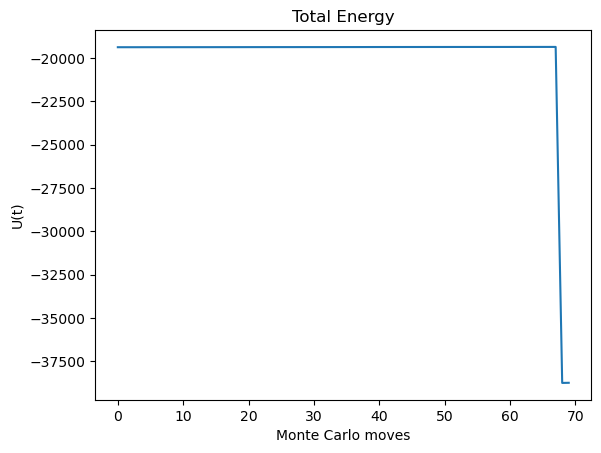

In [31]:
plt.figure()
plt.plot(range(len(Ut)), Ut)
plt.title('Total Energy')
plt.xlabel('Monte Carlo moves')
plt.ylabel('U(t)')

Text(0, 0.5, 'd')

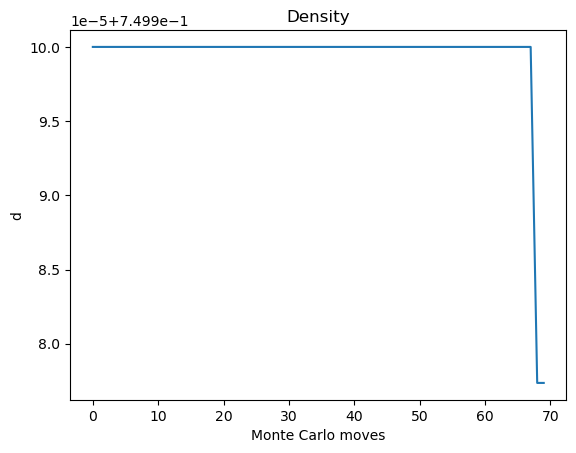

In [32]:
plt.figure()
plt.plot(range(len(rhot)), rhot)
plt.title('Density')
plt.xlabel('Monte Carlo moves')
plt.ylabel('d')

In [33]:
am

68

In [35]:
rm

4882

In [36]:
av

1

In [25]:
rv

49

C:\Users\mhajianz\AppData\Local\Temp\ipykernel_21860\487345633.py:2: RuntimeWarning: invalid value encountered in divide
  gr = gr / rdfps


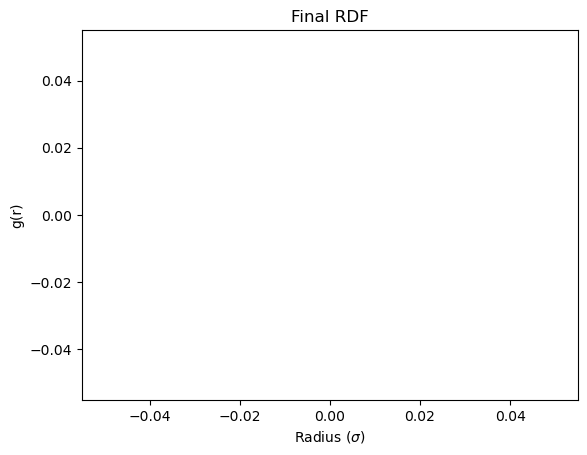

In [7]:
# final average RDF
gr = gr / rdfps
# Plotting RDF
plt.figure()
plt.plot(Radius, gr)
plt.title('Final RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

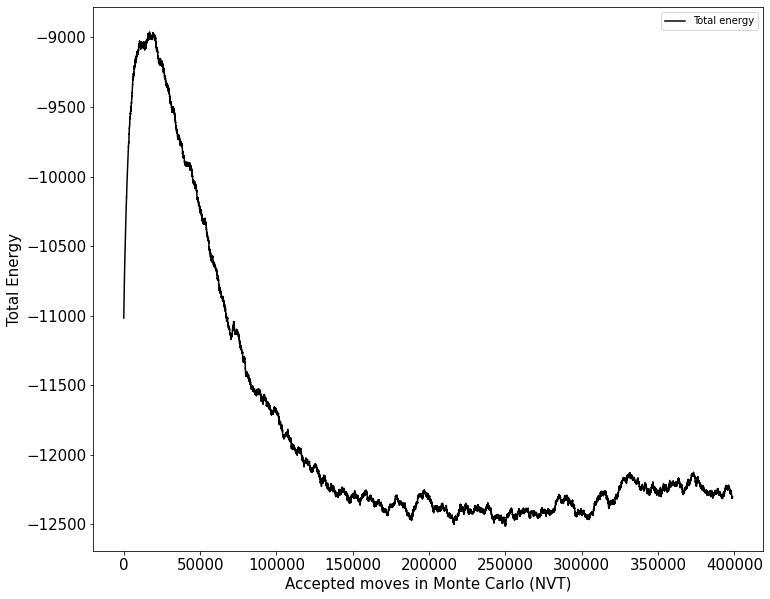

<Figure size 432x288 with 0 Axes>

In [38]:
import pandas as pd
# Read the Excel file
df = pd.read_excel('finalRDF.xlsx', sheet_name='Sheet1')


# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))




# plt.figure(figsize=(8, 6))
plt.plot(df.iloc[:, 0], df.iloc[:, 1], color='black', label='Total energy')
# plt.plot(df.iloc[:, 2], df.iloc[:, 3], color='red')
plt.xlabel('Accepted moves in Monte Carlo (NVT)', fontsize=15)
plt.ylabel('Total Energy',fontsize=15)
plt.xticks(fontsize=15)
# plt.tick_params(labelleft=False, left=False)
plt.legend()
plt.yticks(fontsize=15)
# plt.text(0.05, 0.90, '(a)', transform=plt.gca().transAxes, fontsize=26)
# Display the plot
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('Fig2.png', dpi=1200,bbox_inches='tight')

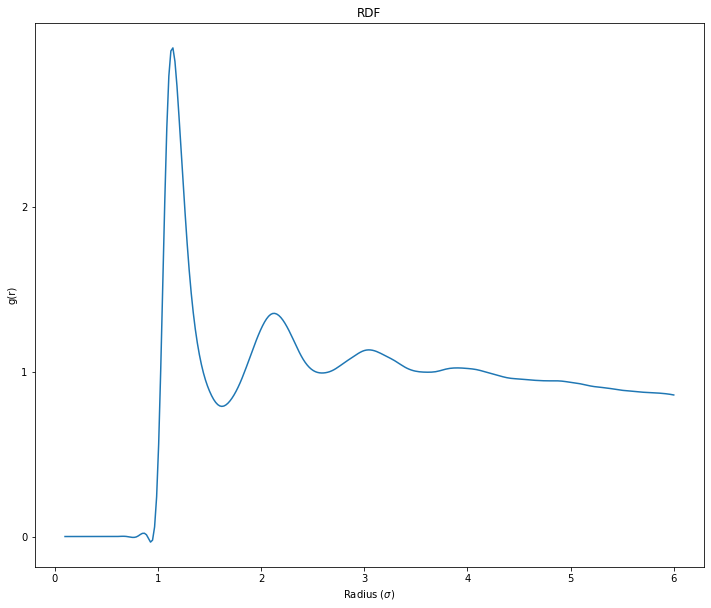

In [41]:
df = pd.read_excel('finalRDF.xlsx', sheet_name='Sheet1')


# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))


from scipy.interpolate import make_interp_spline
# Create a smooth line by interpolating the data
x_smooth = np.linspace(df.iloc[:, 0].min(), df.iloc[:, 0].max(), 300)  # Create 300 evenly spaced points
spline = make_interp_spline(df.iloc[:, 0], df.iloc[:, 1])
y_smooth = spline(x_smooth)
# Plotting RDF
plt.plot(x_smooth, y_smooth)
plt.title('RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.yticks(np.arange(0, math.ceil(max(df.iloc[:, 1])), 1))
plt.show()